In [89]:
#導入要用到的庫
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob as gb
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)
from keras.applications.xception import Xception
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

import sys
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k


In [90]:
img_path = gb("./train/*.PNG")
label = pd.read_csv("./train.csv")

Y_train = label["label"]

y_train = []

for i in label['label']:
    y_train.append([i])
y_train = label['label'].values

y_train.shape

(19,)

In [91]:
label.head()

,name,label
0,0 (1).png,0
1,0 (2).PNG,0
2,0 (3).PNG,0
3,0 (4).PNG,0
4,0 (5).PNG,0


0    8
2    6
1    5
Name: label, dtype: int64

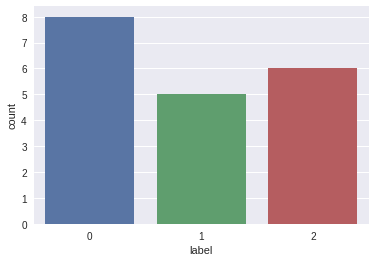

In [92]:
g = sns.countplot(Y_train)

Y_train.value_counts()

In [93]:
name = []
for path in label['name'].values:
    img  = cv2.imread('./train/'+path)
    img2 = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
    del img
    imga = np.asarray(img2)
    name.append(imga)
name = np.array(name)

name.shape

(19, 224, 224, 3)

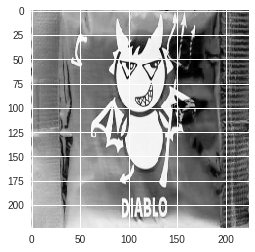

In [94]:
import matplotlib
import matplotlib.pyplot as plt

plt.imshow(name[0][:,:,0])

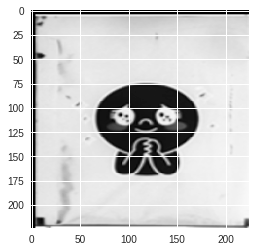

In [95]:
plt.imshow(name[11][:,:,0])

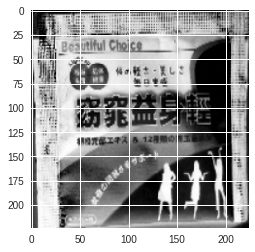

In [96]:
plt.imshow(name[18][:,:,0])

In [97]:
name = name / 255.0  #Normalization

In [98]:
y_train = to_categorical(y_train, num_classes = 3) #one hot

print(y_train[1])

len(y_train)

[ 1.  0.  0.]


19

In [99]:
random_seed = 1 #用random_seed來做作隨機分割

x_train, x_val, y_train, y_val = train_test_split(name, y_train, test_size = 0.3, random_state=random_seed)

# modeling

In [110]:
base_model = Xception(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

    # Top Model Block
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(3, activation='softmax')(x)

    # add your top layer block to your base model
model = Model(base_model.input, predictions)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [111]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [112]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [113]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [114]:
epochs = 30 
batch_size = 2

In [115]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(name)

In [116]:
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 2, steps_per_epoch=name.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 3s - loss: 1.3643 - acc: 0.2235 - val_loss: 1.1208 - val_acc: 0.1667
Epoch 2/30
 - 1s - loss: 1.1564 - acc: 0.2235 - val_loss: 1.0414 - val_acc: 0.5000
Epoch 3/30
 - 1s - loss: 1.0932 - acc: 0.3312 - val_loss: 0.7489 - val_acc: 0.5000
Epoch 4/30
 - 1s - loss: 0.9792 - acc: 0.4471 - val_loss: 0.5507 - val_acc: 0.5000
Epoch 5/30
 - 1s - loss: 0.9524 - acc: 0.5529 - val_loss: 1.0823 - val_acc: 0.6667
Epoch 6/30
 - 1s - loss: 0.9266 - acc: 0.4437 - val_loss: 0.8662 - val_acc: 0.5000
Epoch 7/30
 - 1s - loss: 0.7117 - acc: 0.6147 - val_loss: 0.5459 - val_acc: 0.5000
Epoch 8/30
 - 1s - loss: 0.8005 - acc: 0.5588 - val_loss: 3.1559 - val_acc: 0.5000
Epoch 9/30

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
 - 1s - loss: 1.2205 - acc: 0.6088 - val_loss: 0.8210 - val_acc: 0.5000
Epoch 10/30
 - 1s - loss: 0.8854 - acc: 0.5029 - val_loss: 0.8134 - val_acc: 0.5000
Epoch 11/30
 - 1s - loss: 0.5933 - acc: 0.7188 - val_loss: 0.9154 - val_acc: 0.3333
Epoc

In [118]:
model.save("what.h5")

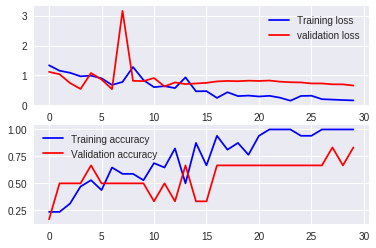

In [119]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# 混淆矩陣

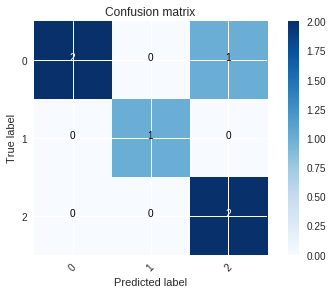

In [120]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

In [121]:
label1 = pd.read_csv("./test.csv")

In [124]:
x_test = [] 
for path in label1['name'].values:
    img  = cv2.imread('./test/'+path+'.PNG')
    img2 = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
    del img
    imga = np.asarray(img2)
    x_test.append(imga)
x_test = np.array(x_test)

x_test.shape

(7, 224, 224, 3)

In [125]:
x_test = x_test.astype('float32') / 255.0

results = model.predict(x_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,8),name = "Id"),results],axis = 1)

submission.to_csv("gg256ss.csv",index=False)